# THE BEST PLACE FOR TWO

# Introduction/Business Problem 

There was described a problem in the beginning of the course: a person needs to relocate and wants to find the same district at the new place.

But it is common when two or more persons participate in the process (a family) and everybody has his/her favorite place.
E.g. he is from Toronto, she is from New York, and they want to live together in Paris.

It is not so easy task because it is not just to find the place close by features to the average place of two.

The goal is to provide a tool to choose the place that is the best for all the persons involved knowing their favorite places.

Who can be interested in such a service:
* alone person who wants to relocate
* a man and a woman (or whoever) who want to live together
* friends (e.g. students) looking for an apartment in the city to live together

So the service will help people to see the start points, areas from which they should start to look for what they want.

# Data 

We will use Foursquare data to retrieve place information, mainly results of explore function because it's free of use.
1. Features of initial place 1
2. Features of initial place 2
3. Features of target places 3 distributed by grid

We will search the best place in the grid (not neighborhoods).

Main information we will extract for every point: quantity of different sections and categories.
So there will be a vector-like description of the points.


Plus we will try to use different functions to merge interests of the persons.
1. Min
2. Average
3. Geometric mean

Having calculated all this data, we will get a color map with recommendations.

# Research

First of all, lets import all the libriries needed

In [1]:
import numpy as np 
import pandas as pd
import folium # map rendering library
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests
import math

And set some constants

In [2]:
CLIENT_ID = 'VL2B4A0DKKQJOMVQR5EZNJHOJHV1SN4QCCNPR240KZQMKTOX' # your Foursquare ID
CLIENT_SECRET = 'WQKUBONPU5QFO50ROUEVZOOI10UXJJ5FUGAKTI0JFEGSCGLG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Foursquare function 'explore' can be used not only with geo coordinates but with a place name as well. It returns venues and geo coordinates of the place in both cases. We will use the fact in the way to get place coordinates by it's name.

In [82]:
def get_coordinates_by_name(city_name):
    ### This function uses Foursquare to get coordinates of the place by its name ###
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            city_name,
            1, 
            1)
    #print(url)
    #print(requests.get(url).json())
    results = requests.get(url).json()["response"]['geocode']
    return {'name':results['displayString'], 'lat':results['center']['lat'], 'lng':results['center']['lng']}

Now lets define our two (or more) favorite places that our hypotetical people like. We can do it directly using geo coordinates or using our function get_coordinates_by_name that returns geo coordinates by the name of the city.

Plus we need the center of our search

In [213]:
favorite_places = []
favorite_places += [{'lat':55.708, 'lng':37.657, 'name':'Moscow-Autozavodskaya'}]
#favorite_places += [{'lat':51.505, 'lng':-0.15, 'name':'London-HydePark'}]
#favorite_places += [{'lat':51.515, 'lng':-0.09, 'name':'London-Center'}]
#favorite_places += [{'lat':40.0, 'lng':-0.09, 'name':'Spain-suburb'}]
#favorite_places += [{'lat':40.8, 'lng':-74.2, 'name':'NewYork'}]
#favorite_places += [{'lat':12.92, 'lng':100.87, 'name':'Thai-Pattaya'}]
favorite_places += [get_coordinates_by_name('Tokio Japan')]

print(favorite_places)

search_place = get_coordinates_by_name('New York')
print('Searching in ' + search_place['name'])

[{'lat': 55.708, 'lng': 37.657, 'name': 'Moscow-Autozavodskaya'}, {'name': 'Tokyo, Tōkyō, Japan', 'lat': 35.6895, 'lng': 139.69171}]
Searching in New York, NY, United States


And show our point on the world map to ensure they are where we want they to see.
The red dots are our favorite places.
The blue dot if out place to search.

In [214]:
map1 = folium.Map(location=[0, 0], zoom_start=2)

for place in favorite_places:
    folium.CircleMarker(
        [place['lat'], place['lng']],
        radius=5,
        popup=place['name'],
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map1)  
    
for place in [search_place]:
    folium.CircleMarker(
        [place['lat'], place['lng']],
        radius=5,
        popup=place['name'],
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map1)  
    
map1

Lets create a grid around the search_place.
It will be a usual square grid.

In [170]:
search_step = 2000  # distance between points and radius for a point search, m
quantity_of_points_from_center = 5

# we can calculate steps of latitude and longitude using geometry
search_lat_step = 360.0 * search_step / 40000000.0 
search_lng_step = 360.0 * search_step / (40000000.0 * math.cos(math.radians(search_place['lat']) ) ) # yes, it depends on lat

search_points = []
for i_lat in range(-quantity_of_points_from_center, quantity_of_points_from_center+1):
    for i_lng in range(-quantity_of_points_from_center, quantity_of_points_from_center+1):
        lat = search_place['lat'] + i_lat * search_lat_step
        lng = search_place['lng'] + i_lng * search_lng_step
        search_points+=[[lat,lng]]

In [176]:
map1 = folium.Map(location=[search_place['lat'], search_place['lng']], zoom_start=11)

for place in search_points:
    folium.CircleMarker(
        place,
        radius=5,
        #popup=place['name'],
        color='black',
        weight=1,
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map1)  
    
map1

As we have already described, we are going to use Big Data of Foursquare to solve our problem.
Foursquare gives us possibility to explore the certain area with explore api function.
The function returns all the venues in the neighbourhood with names, distances, and categories.
Other valuable requests in Foursquare need to have paid tariffs.

So we will get categories of venues for every single point of our grid.
If we use these categories we will get such a sparse matrix that we can doubt it can work.
But if we look at requst data of the 'explore' function, we can find that there are some sections. All this give us a chance ti write api one more time and find a function 'categories' that returns hierarchical categories.

So we will use not initial categories of the venues but their root categories. So we are going to see not sparse matrix in the end.

So lets load the hierarchical categories first.

In [177]:
# Load categories
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            VERSION)

results = requests.get(url).json()["response"]['categories']

def from_json_categories(json_categories, base_categories=[], base_categories_names=[]):
    categories = []
    
    if len(json_categories) == 0:
        return categories
    
    is_root_category = len(base_categories_names)==0
        
    for json_category in json_categories:
        categories += [[json_category['id'], 
                        json_category['name'], 
                        base_categories + [json_category['id']], 
                        base_categories_names + [json_category['name']],
                        is_root_category
                       ]]
        categories += from_json_categories(json_category['categories'], base_categories + [json_category['id']], base_categories_names + [json_category['name']])
        
    return categories;

categories = pd.DataFrame(from_json_categories(results))
categories.columns=['id', 'name', 'parent_ids','parent_names','is_root']

categories.head()

,id,name,parent_ids,parent_names,is_root
0,4d4b7104d754a06370d81259,Arts & Entertainment,[4d4b7104d754a06370d81259],[Arts & Entertainment],True
1,56aa371be4b08b9a8d5734db,Amphitheater,"[4d4b7104d754a06370d81259, 56aa371be4b08b9a8d5...","[Arts & Entertainment, Amphitheater]",False
2,4fceea171983d5d06c3e9823,Aquarium,"[4d4b7104d754a06370d81259, 4fceea171983d5d06c3...","[Arts & Entertainment, Aquarium]",False
3,4bf58dd8d48988d1e1931735,Arcade,"[4d4b7104d754a06370d81259, 4bf58dd8d48988d1e19...","[Arts & Entertainment, Arcade]",False
4,4bf58dd8d48988d1e2931735,Art Gallery,"[4d4b7104d754a06370d81259, 4bf58dd8d48988d1e29...","[Arts & Entertainment, Art Gallery]",False


Now lets write a function that can get data from Foursquare, count categories, and return dataframe with this statistics

In [86]:
def get_statistics(geo_points, radius):
    ### gets statistics of categories by geo point ###
    LIMIT = 1000
    radius = search_step
    
    result_df = pd.DataFrame(columns=['lat','lng'])
    for root_category in categories[categories['is_root']]['name']:
        result_df[root_category]=0
    
    for geo_point in geo_points:
        if isinstance(geo_point,list):
            lat = geo_point[0]
            lng = geo_point[1]
        elif isinstance(geo_point,dict):
            lat = geo_point['lat']
            lng = geo_point['lng']
        else: return None
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        #print(url)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # get venues from the response and their root categories from categories dataframe
        venues = []
        for venue in results:
            venues+=[[venue['venue']['name'], 
                     venue['venue']['location']['distance'], 
                     venue['venue']['categories'][0]['name'], 
                     categories[categories['name'] == venue['venue']['categories'][0]['name']]['parent_names'].item()[0] 
                    ]]
            
        # convert venues to statistics by category 
        search_point_df = pd.DataFrame(venues).groupby([3]).size().reset_index(name='Size')
        search_point_df.columns = ['category', 'size']
        search_point_df.set_index('category', inplace=True)
        search_point_df = search_point_df.transpose()
        search_point_df['lat'] = lat
        search_point_df['lng'] = lng
        
        # add it to result df
        result_df = result_df.append(search_point_df, sort=False)

    
                             
    return(result_df.fillna(0))

Now we can load data from Foursquare for our search places.
Be careful, we are limited to 900 points per day!

In [47]:
search_points_df = get_statistics(search_points,search_step)
search_points_df.head(10)

https://api.foursquare.com/v2/venues/explore?&client_id=VL2B4A0DKKQJOMVQR5EZNJHOJHV1SN4QCCNPR240KZQMKTOX&client_secret=WQKUBONPU5QFO50ROUEVZOOI10UXJJ5FUGAKTI0JFEGSCGLG&v=20180605&ll=40.652184999999996,-74.11138972970244&radius=2000&limit=1000
https://api.foursquare.com/v2/venues/explore?&client_id=VL2B4A0DKKQJOMVQR5EZNJHOJHV1SN4QCCNPR240KZQMKTOX&client_secret=WQKUBONPU5QFO50ROUEVZOOI10UXJJ5FUGAKTI0JFEGSCGLG&v=20180605&ll=40.652184999999996,-74.08763218376195&radius=2000&limit=1000
https://api.foursquare.com/v2/venues/explore?&client_id=VL2B4A0DKKQJOMVQR5EZNJHOJHV1SN4QCCNPR240KZQMKTOX&client_secret=WQKUBONPU5QFO50ROUEVZOOI10UXJJ5FUGAKTI0JFEGSCGLG&v=20180605&ll=40.652184999999996,-74.06387463782146&radius=2000&limit=1000
https://api.foursquare.com/v2/venues/explore?&client_id=VL2B4A0DKKQJOMVQR5EZNJHOJHV1SN4QCCNPR240KZQMKTOX&client_secret=WQKUBONPU5QFO50ROUEVZOOI10UXJJ5FUGAKTI0JFEGSCGLG&v=20180605&ll=40.652184999999996,-74.04011709188097&radius=2000&limit=1000
https://api.foursquare.com/v

https://api.foursquare.com/v2/venues/explore?&client_id=VL2B4A0DKKQJOMVQR5EZNJHOJHV1SN4QCCNPR240KZQMKTOX&client_secret=WQKUBONPU5QFO50ROUEVZOOI10UXJJ5FUGAKTI0JFEGSCGLG&v=20180605&ll=40.706185,-74.06387463782146&radius=2000&limit=1000
https://api.foursquare.com/v2/venues/explore?&client_id=VL2B4A0DKKQJOMVQR5EZNJHOJHV1SN4QCCNPR240KZQMKTOX&client_secret=WQKUBONPU5QFO50ROUEVZOOI10UXJJ5FUGAKTI0JFEGSCGLG&v=20180605&ll=40.706185,-74.04011709188097&radius=2000&limit=1000
https://api.foursquare.com/v2/venues/explore?&client_id=VL2B4A0DKKQJOMVQR5EZNJHOJHV1SN4QCCNPR240KZQMKTOX&client_secret=WQKUBONPU5QFO50ROUEVZOOI10UXJJ5FUGAKTI0JFEGSCGLG&v=20180605&ll=40.706185,-74.01635954594049&radius=2000&limit=1000
https://api.foursquare.com/v2/venues/explore?&client_id=VL2B4A0DKKQJOMVQR5EZNJHOJHV1SN4QCCNPR240KZQMKTOX&client_secret=WQKUBONPU5QFO50ROUEVZOOI10UXJJ5FUGAKTI0JFEGSCGLG&v=20180605&ll=40.706185,-73.992602&radius=2000&limit=1000
https://api.foursquare.com/v2/venues/explore?&client_id=VL2B4A0DKKQJOMVQ

https://api.foursquare.com/v2/venues/explore?&client_id=VL2B4A0DKKQJOMVQR5EZNJHOJHV1SN4QCCNPR240KZQMKTOX&client_secret=WQKUBONPU5QFO50ROUEVZOOI10UXJJ5FUGAKTI0JFEGSCGLG&v=20180605&ll=40.760185,-73.992602&radius=2000&limit=1000
https://api.foursquare.com/v2/venues/explore?&client_id=VL2B4A0DKKQJOMVQR5EZNJHOJHV1SN4QCCNPR240KZQMKTOX&client_secret=WQKUBONPU5QFO50ROUEVZOOI10UXJJ5FUGAKTI0JFEGSCGLG&v=20180605&ll=40.760185,-73.96884445405952&radius=2000&limit=1000
https://api.foursquare.com/v2/venues/explore?&client_id=VL2B4A0DKKQJOMVQR5EZNJHOJHV1SN4QCCNPR240KZQMKTOX&client_secret=WQKUBONPU5QFO50ROUEVZOOI10UXJJ5FUGAKTI0JFEGSCGLG&v=20180605&ll=40.760185,-73.94508690811904&radius=2000&limit=1000
https://api.foursquare.com/v2/venues/explore?&client_id=VL2B4A0DKKQJOMVQR5EZNJHOJHV1SN4QCCNPR240KZQMKTOX&client_secret=WQKUBONPU5QFO50ROUEVZOOI10UXJJ5FUGAKTI0JFEGSCGLG&v=20180605&ll=40.760185,-73.92132936217855&radius=2000&limit=1000
https://api.foursquare.com/v2/venues/explore?&client_id=VL2B4A0DKKQJOMVQ

https://api.foursquare.com/v2/venues/explore?&client_id=VL2B4A0DKKQJOMVQR5EZNJHOJHV1SN4QCCNPR240KZQMKTOX&client_secret=WQKUBONPU5QFO50ROUEVZOOI10UXJJ5FUGAKTI0JFEGSCGLG&v=20180605&ll=40.814185,-73.92132936217855&radius=2000&limit=1000
https://api.foursquare.com/v2/venues/explore?&client_id=VL2B4A0DKKQJOMVQR5EZNJHOJHV1SN4QCCNPR240KZQMKTOX&client_secret=WQKUBONPU5QFO50ROUEVZOOI10UXJJ5FUGAKTI0JFEGSCGLG&v=20180605&ll=40.814185,-73.89757181623806&radius=2000&limit=1000
https://api.foursquare.com/v2/venues/explore?&client_id=VL2B4A0DKKQJOMVQR5EZNJHOJHV1SN4QCCNPR240KZQMKTOX&client_secret=WQKUBONPU5QFO50ROUEVZOOI10UXJJ5FUGAKTI0JFEGSCGLG&v=20180605&ll=40.814185,-73.87381427029757&radius=2000&limit=1000
https://api.foursquare.com/v2/venues/explore?&client_id=VL2B4A0DKKQJOMVQR5EZNJHOJHV1SN4QCCNPR240KZQMKTOX&client_secret=WQKUBONPU5QFO50ROUEVZOOI10UXJJ5FUGAKTI0JFEGSCGLG&v=20180605&ll=40.832185,-74.11138972970244&radius=2000&limit=1000
https://api.foursquare.com/v2/venues/explore?&client_id=VL2B4A0D

Lets see some category distribution across the whole area just to check that everything goes well.

In [180]:
map1 = folium.Map(location=[search_place['lat'], search_place['lng']], zoom_start=11)

#by = 'Food'
#by = 'Travel & Transport'
by = 'Outdoors & Recreation'
#by = 'Shop & Service'

value_max = search_points_df[by].max()

for place in search_points_df[['lat','lng',by]].values:
    folium.CircleMarker(
        place[0:2],
        radius=5,
        #popup=place['name'],
        color='grey',
        weight=0,
        fill=True,
        fill_color='blue',
        fill_opacity=place[2]/value_max,
        parse_html=False).add_to(map1)  
    
map1

Some step of data preparation was described early: get root categories.

Now we can notice another stuff: some root categories are actually not used:
* College & University
* Event


So let's drop these columns.

In [50]:
search_points_df.drop(['College & University', 'Event'], axis='columns', inplace=True)
search_points_df.head()

,lat,lng,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
size,40.652185,-74.111390,4.0,46.0,6.0,9,1.0,0.0,26,6.0
size,40.652185,-74.087632,13.0,39.0,6.0,10,4.0,0.0,14,14.0
size,40.652185,-74.063875,6.0,33.0,5.0,7,1.0,0.0,4,15.0
size,40.652185,-74.040117,1.0,5.0,0.0,10,0.0,0.0,3,10.0
size,40.652185,-74.016360,5.0,67.0,4.0,6,1.0,0.0,16,1.0
size,40.652185,-73.992602,2.0,57.0,11.0,9,3.0,0.0,18,0.0
size,40.652185,-73.968844,4.0,50.0,8.0,19,3.0,0.0,16,0.0
size,40.652185,-73.945087,3.0,61.0,9.0,8,1.0,0.0,18,0.0
size,40.652185,-73.921329,3.0,56.0,1.0,7,1.0,0.0,32,0.0
size,40.652185,-73.897572,2.0,55.0,1.0,6,0.0,0.0,36,0.0


Now if we look at the freaquances of the categories, we will find they are not balanced.
Food category is so huge that it will shadow all others summarised!
This leads us to the next step of data preparation: normalization

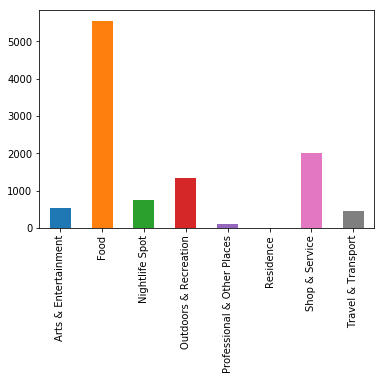

In [179]:
# lets see distribution by category. They are not equal. Food is an absolute leader.
search_points_df.iloc[:,2:].sum().plot.bar()

WE have several choises to normilize data.
One is to find sum in each category.

Lets define categories_weight as a coefficient we will need to multiply to in case to normalize our columns.

In [56]:
categories_weight_df = search_points_df.iloc[:,2:].sum()
categories_weight_df = categories_weight_df.sum() / categories_weight_df
categories_weight_df

Arts & Entertainment             20.445714
Food                              1.931965
Nightlife Spot                   14.331108
Outdoors & Recreation             7.998510
Professional & Other Places     105.235294
Residence                      2683.500000
Shop & Service                    5.337643
Travel & Transport               24.121348
dtype: float64

We see that 'Professional & Other Places' and 'Residence' have inadequate weights because of their rare appearance in data.
Lets set it at the level of the previous big value.

In [181]:
categories_weight_df['Professional & Other Places'] = 0
categories_weight_df['Residence'] = 0
categories_weight_df['Professional & Other Places'] = categories_weight_df.max()
categories_weight_df['Residence'] = categories_weight_df.max()
# and normilize to 1
categories_weight_df = categories_weight_df / categories_weight_df.sum()
categories_weight_df

Arts & Entertainment           0.167028
Food                           0.015783
Nightlife Spot                 0.117076
Outdoors & Recreation          0.065343
Professional & Other Places    0.197055
Residence                      0.197055
Shop & Service                 0.043605
Travel & Transport             0.197055
dtype: float64

Now lets get statistics of favorite places as well

In [215]:
favorite_places_df = get_statistics(favorite_places,search_step)
favorite_places_df.drop(['College & University', 'Event'], axis='columns', inplace=True)
favorite_places_df

,lat,lng,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
size,55.7080,37.65700,17,29,4,17,2.0,0.0,31,0.0
size,35.6895,139.69171,7,60,14,2,0.0,0.0,12,5.0


# Calculation
In this section we will calculate some statistics and make something like a recommendation system.


In order to do math, lets change data types from dataframes to arrays.

Plus we are going to take into account the total quantity of venues, normilized by weights.
Moreover, because we want to have a column that is approximately normalized to others, we need to add not Sum but Mean.

In [185]:
categories_weight = categories_weight_df.values
categories_weight

array([0.16702789, 0.01578287, 0.11707562, 0.0653425 , 0.19705537,
       0.19705537, 0.04360499, 0.19705537])

In [216]:
favorite_places_stat = favorite_places_df.values[:,2:]
# Multiply weights
favorite_places_stat = favorite_places_stat * categories_weight
# Add additional feature that is sum of normalized number of venues (place popularity). Actually we get mean
favorite_places_stat = np.column_stack((favorite_places_stat, favorite_places_stat.mean(axis=1)))
# Normilize || * || = 1
favorite_places_stat = favorite_places_stat / ((favorite_places_stat**2).sum(axis=1)**0.5).reshape(len(favorite_places_stat),1)
favorite_places_stat

array([[0.80658062, 0.13001514, 0.13302594, 0.31554011, 0.11195104,
        0.        , 0.38397928, 0.        , 0.23513652],
       [0.45282873, 0.36676193, 0.63480664, 0.05061424, 0.        ,
        0.        , 0.20265831, 0.38159725, 0.26115839]])

Now we have two tables:
1. The data of search_places (many rows)
2. Tha data of favorite places (two or more rows)

The place is devied by us as the best if it is similar to the favorite place.
We actually have two sets of unit vectors. The most popular way of finding similarity is dot product.

To have more contrast, lets powered it by 2.

In [217]:
search_points_result = np.dot(search_points_stat, np.transpose(favorite_places_stat))
search_points_result = search_points_result
search_points_result[:5,:]

array([[0.68380871, 0.85119222],
       [0.68092446, 0.79142554],
       [0.40695391, 0.71647553],
       [0.23074487, 0.47793564],
       [0.81047886, 0.82505132]])

Now we have every point its 'similarity' to the 1st, 2nd, .. favorite places (stored in columns)
Let's see the result on the map for 2 places:
1. Bigger size is better for the 1st
2. More opaque is better for the 2nd

We see that there are some good places for one but not for another: semitransparent big circles and opaque small dots.
Good news is there are some opaque big circles.

In [218]:
dmin = search_points_result.min()
dmax = search_points_result.max()

map1 = folium.Map(location=[search_place['lat'], search_place['lng']], zoom_start=11)

value_max = search_points_df[by].max()

for place, data in zip(search_points, search_points_result):
    folium.CircleMarker(
        place,
        radius=10*(data[0]-dmin)/(dmax-dmin),
        #popup=place['name'],
        color='grey',
        weight=0,
        fill=True,
        fill_color='blue',
        fill_opacity=(data[1]-dmin)/(dmax-dmin),
        parse_html=False).add_to(map1)  
    
map1

Thought it is a pretty good and useful result for two persons, it is not easy to show it for 3 or more people.
So lets try some combining operators.
The 1st one is simple 'min' that allows to see the minimal result for the group.
So after it we can start to look for a flat in just several districts of the city.

Here radius and opaque coefficient are both linear to the same value (min data).

In [219]:
dmin = search_points_result.min()
dmax = search_points_result.max()

map1 = folium.Map(location=[search_place['lat'], search_place['lng']], zoom_start=11)

value_max = search_points_df[by].max()

for place, data in zip(search_points, search_points_result):
    folium.CircleMarker(
        place,
        radius=10*(data.min()-dmin)/(dmax-dmin),
        #popup=place['name'],
        color='grey',
        weight=0,
        fill=True,
        fill_color='blue',
        fill_opacity=(data.min()-dmin)/(dmax-dmin),
        parse_html=False).add_to(map1)  
    
map1

Another option is to use some average value, e.g. mean or geometric mean. In practrice they are pretty the same here.
It allows to see wider varieties.

In [203]:
dmin = search_points_result.min()
dmax = search_points_result.max()

map1 = folium.Map(location=[search_place['lat'], search_place['lng']], zoom_start=11)

value_max = search_points_df[by].max()

for place, data in zip(search_points, search_points_result):
    folium.CircleMarker(
        place,
        radius=10*(data.mean()-dmin)/(dmax-dmin),
        #popup=place['name'],
        color='grey',
        weight=0,
        fill=True,
        fill_color='blue',
        fill_opacity=(data.mean()-dmin)/(dmax-dmin),
        parse_html=False).add_to(map1)  
    
map1

In [204]:
def gmean(array):
    ### geometrical mean  ###
    return np.exp(np.log(array).mean())
    

dmin = search_points_result.min()
dmax = search_points_result.max()

map1 = folium.Map(location=[search_place['lat'], search_place['lng']], zoom_start=11)

value_max = search_points_df[by].max()

for place, data in zip(search_points, search_points_result):
    folium.CircleMarker(
        place,
        radius=10*(gmean(data)-dmin)/(dmax-dmin),
        #popup=place['name'],
        color='grey',
        weight=0,
        fill=True,
        fill_color='blue',
        fill_opacity=(gmean(data)-dmin)/(dmax-dmin),
        parse_html=False).add_to(map1)  
    
map1